<h1 align="center" > Segmenting and Clustering Neighborhoods in Toronto

<h3> <a id="toc"> Table of Contents </a> </h3>

<ol>
    <li> 
        <h4> <a href="#prepa">Preparation</a> </h4>
    </li>
    <li>
        <h4> <a href="#neighexplore"> Exploration of Neighborhoods </a> </h4>
    </li>  
    <li>
        <h4> <a href="#analyze"> Analyze Each Neighborhoods </a> </h4>
    </li>
    <li>
        <h4> <a href="#cluster"> Cluster Neighborhoods </a> </h4>
    </li>
    <li>
        <h4> <a href="#examine"> Examine Clusters </a> </h4>
    </li>
</ol>



<h2> <a id="prepa"> <a href="toc"> 1. Preparations </a>  </a> </h2>

<h3> <a id="import"> <a href="#toc"> 1.1 Importing packages </a> </a> </h3>

In [3]:
# if needed to install the packages
# !pip install folium

In [4]:
from collections import defaultdict
# importing pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#importing numpy 
import numpy as np
import matplotlib.pyplot as plt
import folium
import requests
import json

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
import geocoder # convert an address into latitude and longitude values

##Wordcloud 
from wordcloud import WordCloud, STOPWORDS
print("Import Done")

Import Done


<h3> <a id="load"> <a href="#toc"> 1.2 Load data </a> </a> </h3>

In [5]:
toronto_geo_data = pd.read_csv('data/toronto_geo_data.csv')
toronto_geo_data.head()

,Unnamed: 0,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,0,M3A,North York,Parkwoods,43.752420,-79.329242
1,1,M4A,North York,Victoria Village,43.730600,-79.313265
2,2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.650295,-79.359166
3,3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.723270,-79.451286
4,4,M7A,Queen's Park,Queen's Park,43.661150,-79.391715


<h3> <a id="dataprep"> <a href="#toc"> 1.3 Data Preparation </a> </a> </h3>

Remove the "Unnamed: 0" column from dataframe

In [6]:
toronto_geo_data.drop('Unnamed: 0', axis=1, inplace=True)
toronto_geo_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752420,-79.329242
1,M4A,North York,Victoria Village,43.730600,-79.313265
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.650295,-79.359166
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.723270,-79.451286
4,M7A,Queen's Park,Queen's Park,43.661150,-79.391715


Testing the Foursquare API on arbitrary postal code 'M5H'

In [7]:
## Example neighbourhood
test_neigh = 'M5H'
neighborhood_latitude =toronto_geo_data[toronto_geo_data['PostalCode']==test_neigh]['Latitude'].iloc[0]
neighborhood_longitude = toronto_geo_data[toronto_geo_data['PostalCode']==test_neigh]['Longitude'].iloc[0]

In [8]:
radius = 500
limit = 100
VERSION = '20191101'
sortByPopularity = 1
print(neighborhood_latitude)
url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}".format(
    CLIENT_ID, CLIENT_SECRET, neighborhood_latitude,neighborhood_longitude, VERSION,radius, limit)

43.649700000000045


In [9]:
results = requests.get(url).json()

In [10]:
# results

Printing the venues for the postal code with their corresponding category

In [11]:
for item in results['response']['groups'][0]['items']:
    print(item['venue']['name'],": ", item['venue']['categories'][0]['name'] )


The Keg Steakhouse & Bar :  Steakhouse
Cactus Club Cafe :  American Restaurant
Adelaide Club Toronto :  Gym / Fitness Center
John & Sons Oyster House :  Seafood Restaurant
Pilot Coffee Roasters :  Coffee Shop
King Taps :  Gastropub
Rosalinda :  Vegetarian / Vegan Restaurant
Maman :  Café
Pizzeria Libretto :  Pizza Place
Canoe :  Restaurant
Four Seasons Centre for the Performing Arts :  Concert Hall
Brick Street Bakery :  Bakery
Equinox Bay Street :  Gym
The Gabardine :  American Restaurant
Estiatorio Volos :  Greek Restaurant
Assembly Chef's Hall :  Food Court
Bulldog On The Block :  Coffee Shop
Noodle King :  Asian Restaurant
Sam James Coffee Bar (SJCB) :  Café
Nathan Phillips Square :  Plaza
Hy's Steakhouse :  Steakhouse
Cafe Landwer :  Café
Pumpernickel's Deli :  Deli / Bodega
M Square Coffee Co :  Coffee Shop
Bosk at Shangri-La :  Asian Restaurant
Boxcar Social Temperance :  Bar
Old City Hall :  Monument / Landmark
Dineen Coffee :  Café
Shangri-La Toronto :  Hotel
iQ Food Co. (Firs

<h2> <a id="neighexplore"> <a href="#toc"> 2. Exploration of Neighborhoods </a> </a>  </h2>

Define function to retrieve for each neighbourhod with given latitude and longitude, all the venues in the radius of 500m.

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# Select only boroughscontaining "Toronto" in them 
toronto_borough = toronto_geo_data[toronto_geo_data['Borough'].str.contains('Toronto')]

Retrieve 100 venues for those selected boroughs and their neighborhoods

In [14]:
LIMIT = 100
toronto_borough_venues = getNearbyVenues(toronto_borough['Neighborhood'], toronto_borough['Latitude'], toronto_borough['Longitude'])

In [15]:
print(toronto_borough_venues.shape)
toronto_borough_venues.head()

(1752, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Harbourfront, Regent Park",43.650295,-79.359166,The Distillery Historic District,43.650244,-79.359323,Historic Site
1,"Harbourfront, Regent Park",43.650295,-79.359166,Arvo,43.649963,-79.361442,Coffee Shop
2,"Harbourfront, Regent Park",43.650295,-79.359166,Distillery Sunday Market,43.650075,-79.361832,Farmers Market
3,"Harbourfront, Regent Park",43.650295,-79.359166,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop
4,"Harbourfront, Regent Park",43.650295,-79.359166,Cacao 70,43.650067,-79.360723,Dessert Shop


In [16]:
#Drop the venues categorised as "Neighborhood"
toronto_borough_venues = toronto_borough_venues[toronto_borough_venues['Venue Category']!='Neighborhood']

In [17]:
#Number of unique venue categories
print(len(toronto_borough_venues['Venue Category'].unique()))

215


<h2> <a id="analyze"> <a href="#toc"> 3. Analyze each neighborhoods </a> </a>  </h2>

One Hot Encoding and preparation for Clustering

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_borough_venues[['Venue Category']], prefix="", prefix_sep="")


# add neighborhood column back to dataframe in first position
toronto_onehot.insert(0, 'Neighborhood', toronto_borough_venues['Neighborhood'])  



In [19]:
toronto_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Harbourfront, Regent Park",0

In [20]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [21]:
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.030303,0.0,0.010101,0.0,0.000000,0.030303,0.0,0.000000,0.0,0.000000,0.030303,0.0,0.030303,0.000000,0.0,0.010101,0.0,0.0,0.000000,0.0,0.020202,0.0,0.010101,0.030303,0.000000,0.0,0.010101,0.020202,0.010101,0.0,0.000000,0.060606,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.080808,0.0,0.000000,0.0,0.00,0.000000,0.0,0.020202,0.0,0.010101,0.000000,0.0,0.0,0.0,0.00,0.020202,0.010101,0.010101,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.010101,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.010101,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.030303,0.0,0.0,0.010101,0.000000,0.010101,0.000000,0.010101,0.000000,0.020202,0.010101,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.050505,0.000000,0.0,0.010101,0.000000,0.000000,0.010101,0.030303,0.000000,0.0,0.000000,0.0,0.0,0.010101,0.000000,0.0,0.000000,0.010101,0.0,0.0,0.000000,0.00,0.000000,0.0

In [22]:
toronto_grouped.shape

(37, 216)

#### Printing top 5 venus for each neighbourhood

In [23]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.08
1                 Café  0.06
2                Hotel  0.05
3           Steakhouse  0.04
4  American Restaurant  0.03


----Berczy Park----
                venue  freq
0         Coffee Shop  0.08
1          Restaurant  0.05
2          Steakhouse  0.03
3  Seafood Restaurant  0.03
4            Beer Bar  0.03


----Brockton, Exhibition Place, Parkdale Village----
                    venue  freq
0             Coffee Shop  0.10
1                    Café  0.07
2  Furniture / Home Store  0.06
3              Restaurant  0.06
4          Sandwich Place  0.04


----Business Reply Mail Processing Centre 969 Eastern----
         venue  freq
0  Coffee Shop  0.11
1          Bar  0.04
2   Steakhouse  0.04
3        Hotel  0.04
4         Café  0.04


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
                  venue  freq
0           Coffee Shop

Create a dataframe with top 10 venues for each neighborhood

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Hotel,Steakhouse,Gastropub,Bakery,Breakfast Spot,Asian Restaurant,Restaurant,Japanese Restaurant
1,Berczy Park,Coffee Shop,Restaurant,Cocktail Bar,Italian Restaurant,Steakhouse,Bakery,Farmers Market,Beer Bar,Breakfast Spot,Hotel
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Restaurant,Furniture / Home Store,Bakery,Sandwich Place,Beer Bar,Supermarket,Bar,Vegetarian / Vegan Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Coffee Shop,Bar,Café,Hotel,Steakhouse,American Restaurant,Restaurant,Pub,Pizza Place,Sushi Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Coffee Shop,Italian Restaurant,Restaurant,Park,Pub,Speakeasy,Café,Bar,Bakery,Sandwich Place


<h2> <a id="cluster"> <a href="#toc"> 4. Cluster Neighborhoods  </a> </a>  </h2>

<h3> <a id="clustering"> <a href="#toc"> 4.1 Clustering of Neighborhoods  </a> </a>  </h2>

In [26]:
kclusters = 5

toronto_grouped_cluster = toronto_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0)

kmeans.fit(toronto_grouped_cluster)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [27]:
kmeans.labels_

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 1, 4, 1, 4, 0,
       2, 4, 0, 0, 4, 0, 4, 4, 4, 4, 4, 4, 3, 4, 0], dtype=int32)

In [28]:
# add cluster labels to dataframe
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


toronto_merged = toronto_borough

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.650295,-79.359166,4.0,Coffee Shop,Bakery,Café,Theater,Boat or Ferry,Mexican Restaurant,Performing Arts Venue,Pub,Farmers Market,Chocolate Shop
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657363,-79.378180,4.0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Fast Food Restaurant,Japanese Restaurant,Restaurant,Sporting Goods Shop,Ramen Restaurant
15,M5C,Downtown Toronto,St. James Town,43.651210,-79.375481,4.0,Coffee Shop,Café,Hotel,Restaurant,Bakery,Seafood Restaurant,Breakfast Spot,Gastropub,Italian Restaurant,Cosmetics Shop
19,M4E,East Toronto,The Beaches,43.676531,-79.295425,3.0,Health Food Store,Pub,Trail,Donut Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
20,M5E,Downtown Toronto,Berczy Park,43.645160,-79.373675,4.0,Coffee Shop,Restaurant,Cocktail Bar,Italian Restaurant,Steakhouse,Bakery,Farmers Market,Beer Bar,Breakfast Spot,Hotel


In [29]:
# toronto_merged

In [30]:
# delete Neighborhood Roselawn as it does not have venues found
toronto_merged.drop(index=62, inplace=True)

# transform labels column into int 
toronto_merged = toronto_merged.astype({'Cluster Labels': int})
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.650295,-79.359166,4,Coffee Shop,Bakery,Café,Theater,Boat or Ferry,Mexican Restaurant,Performing Arts Venue,Pub,Farmers Market,Chocolate Shop
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657363,-79.378180,4,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Fast Food Restaurant,Japanese Restaurant,Restaurant,Sporting Goods Shop,Ramen Restaurant
15,M5C,Downtown Toronto,St. James Town,43.651210,-79.375481,4,Coffee Shop,Café,Hotel,Restaurant,Bakery,Seafood Restaurant,Breakfast Spot,Gastropub,Italian Restaurant,Cosmetics Shop
19,M4E,East Toronto,The Beaches,43.676531,-79.295425,3,Health Food Store,Pub,Trail,Donut Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
20,M5E,Downtown Toronto,Berczy Park,43.645160,-79.373675,4,Coffee Shop,Restaurant,Cocktail Bar,Italian Restaurant,Steakhouse,Bakery,Farmers Market,Beer Bar,Breakfast Spot,Hotel


In [31]:
# toronto_merged

In [32]:
adress = "Toronto, Ontario"

g = geocoder.arcgis(adress)

latitude = g.latlng[0]
longitude = g.latlng[1]
print(latitude)
print(longitude)

43.648690000000045
-79.38543999999996


<h3> <a id="clustermap"> <a href="#toc"> 4.2 Clusters on Map of Toronto  </a> </a>  </h3>

Visualize the clusters on map of Toronto

In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


In [41]:
map_clusters


<h3> <a id="examine"> <a href="#toc"> 5. Examine Clusters  </a> </a>  </h3>

Here we will examine each cluster.

In [42]:
# list of columns of 10 most common values
lc = list(toronto_merged.columns[6:])

# for wordcloud 
stopwords = set(STOPWORDS)
stopwords.update(["restaurant"])

# set parameters for plots
fontparam = {'fontsize':32, 'fontweight':10}

<h4> <a id="cluster0"> <a href="#toc"> Cluster 0  </a> </a>  </h4>

In [43]:
cluster0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5,toronto_merged.shape[1]))]]
cluster0.head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,East Toronto,0,Bus Line,Park,Grocery Store,Discount Store,Yoga Studio,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
67,Central Toronto,0,Bus Line,Hotel,Clothing Store,Dog Run,Park,Breakfast Spot,Gym,Convenience Store,Food & Drink Shop,Fish & Chips Shop
69,West Toronto,0,Sandwich Place,Convenience Store,Park,Bed & Breakfast,Dumpling Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm
73,Central Toronto,0,Playground,Gym Pool,Park,Garden,Donut Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
83,Central Toronto,0,Convenience Store,Playground,Gym,Restaurant,Donut Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
91,Downtown Toronto,0,Playground,Grocery Store,Park,Candy Store,Yoga Studio,Dumpling Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm


In [44]:
dic0 = defaultdict(int)
for c in lc:
    ds = cluster0[c].value_counts()
    for i in ds.index:
        dic0[i.lower()] += ds[i]
    

In [45]:
cl0 = WordCloud(width=1280, height=853,background_color='white', stopwords=stopwords).generate_from_frequencies(dic0)

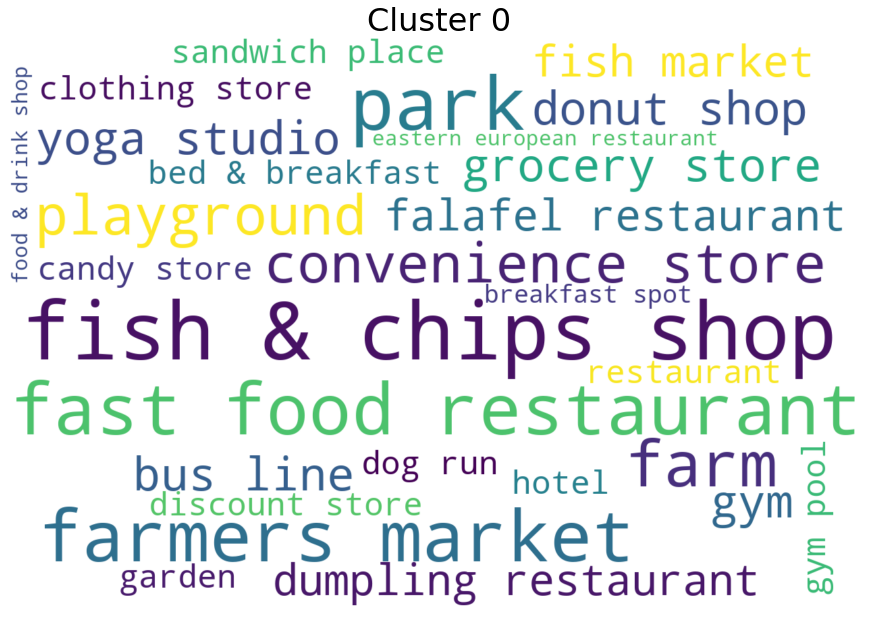

In [46]:
# plot the WordCloud image                        
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(cl0, interpolation="bilinear") 
plt.axis("off") 
plt.title("Cluster 0", fontdict=fontparam)
plt.tight_layout(pad = 0) 
  
plt.show() 

<h4> <a id="cluster1"> <a href="#toc"> Cluster 1  </a> </a>  </h4>

In [47]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5,toronto_merged.shape[1]))]]
cluster1.head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Downtown Toronto,1,Harbor / Marina,Pier,Park,Yoga Studio,Donut Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
68,Central Toronto,1,Park,Yoga Studio,Dumpling Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


In [48]:
dic1 = defaultdict(int)
for c in lc:
    ds = cluster1[c].value_counts()
    for i in ds.index:
        dic1[i.lower()] += ds[i]
    

In [49]:
cl1 = WordCloud(width=1280, height=853, background_color='white', stopwords=stopwords).generate_from_frequencies(dic1)

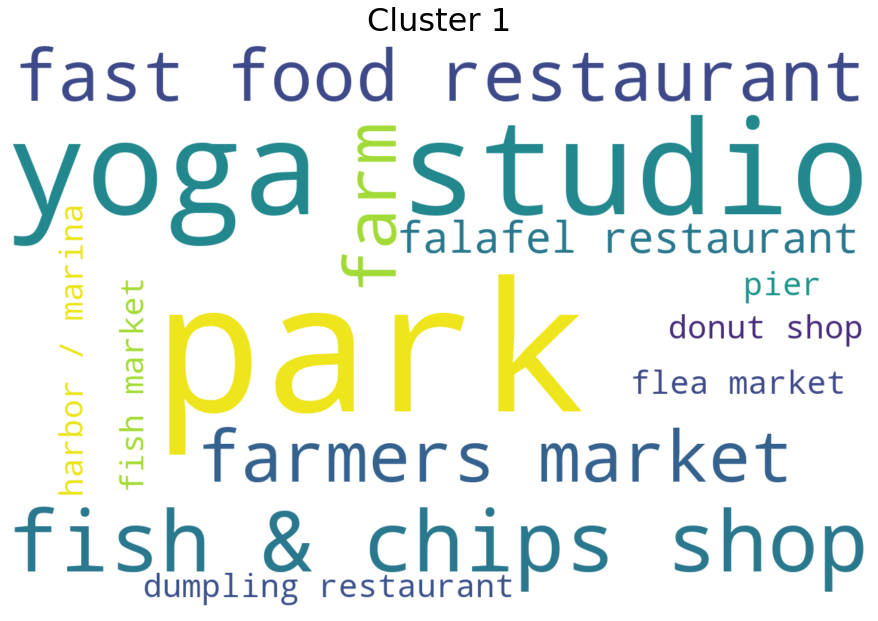

In [50]:
# plot the WordCloud image                        
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(cl1, interpolation="bilinear") 
plt.axis("off") 
plt.title("Cluster 1", fontdict=fontparam)
plt.tight_layout(pad = 0) 
  
plt.show() 

<h4> <a id="cluster2"> <a href="#toc"> Cluster 2  </a> </a>  </h4>

In [51]:
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5,toronto_merged.shape[1]))]]
cluster2.head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Central Toronto,2,Bus Line,Swim School,Yoga Studio,Food,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm


In [52]:
dic2 = defaultdict(int)
for c in lc:
    ds = cluster2[c].value_counts()
    for i in ds.index:
        dic2[i.lower()] += ds[i]
   

In [53]:
cl2 = WordCloud(width=1280, height=853,background_color='white', stopwords=stopwords).generate_from_frequencies(dic2)

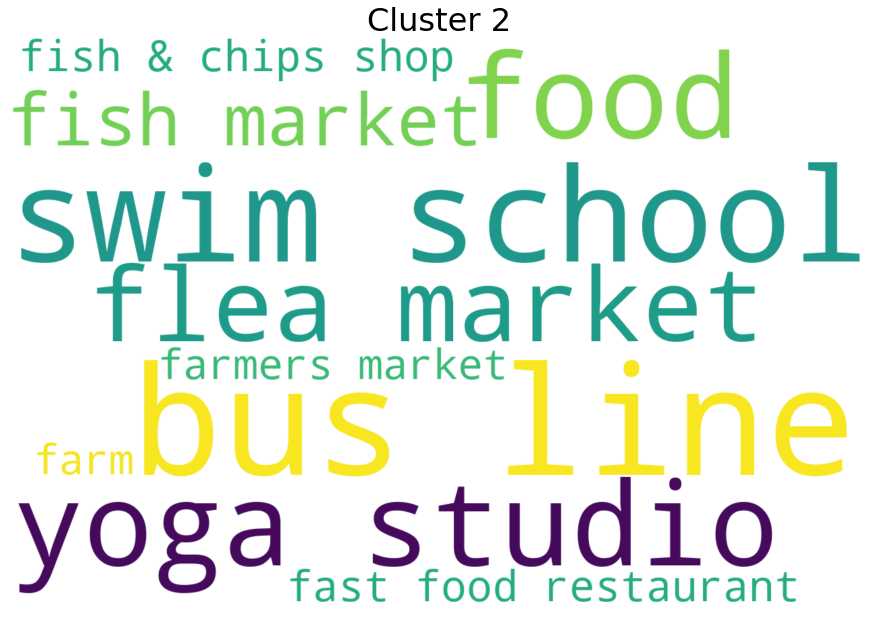

In [54]:
# plot the WordCloud image                        
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(cl2, interpolation="bilinear") 
plt.axis("off") 
plt.title("Cluster 2", fontdict=fontparam)
plt.tight_layout(pad = 0) 
  
plt.show() 

<h4> <a id="cluster3"> <a href="#toc"> Cluster 3  </a> </a>  </h4>

In [55]:
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5,toronto_merged.shape[1]))]]
cluster3.head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,East Toronto,3,Health Food Store,Pub,Trail,Donut Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


In [56]:
dic3 = defaultdict(int)
for c in lc:
    ds = cluster3[c].value_counts()
    for i in ds.index:
        dic3[i.lower()] += ds[i]
 

In [57]:
cl3 = WordCloud(width=1280, height=853, background_color='white', stopwords=stopwords).generate_from_frequencies(dic3)

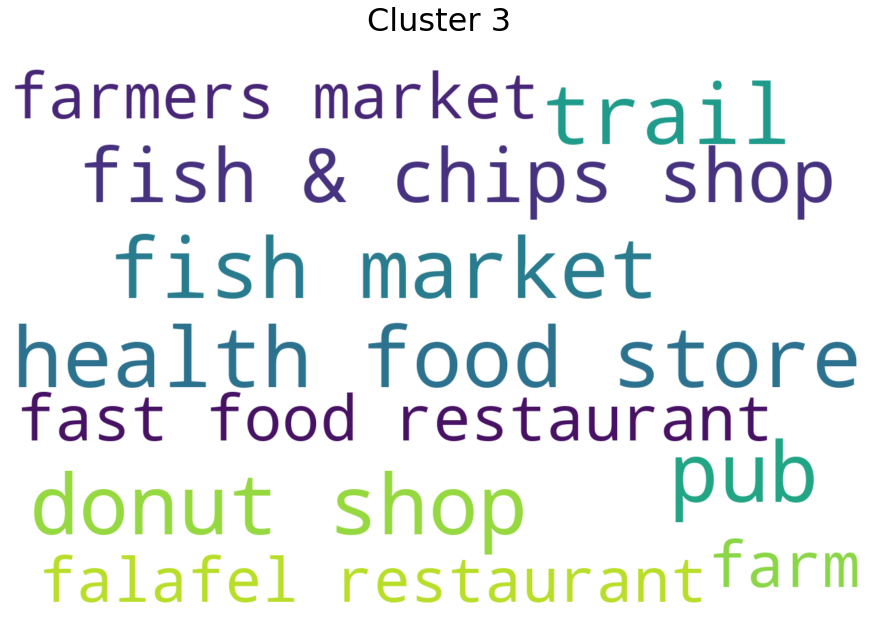

In [58]:
# plot the WordCloud image                        
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(cl3, interpolation="bilinear") 
plt.axis("off") 
plt.title("Cluster 3", fontdict=fontparam)
plt.tight_layout(pad = 0) 
  
plt.show() 

<h4> <a id="cluster4"> <a href="#toc"> Cluster 4  </a> </a>  </h4>

In [59]:
cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5,toronto_merged.shape[1]))]]
cluster4.head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,4,Coffee Shop,Bakery,Café,Theater,Boat or Ferry,Mexican Restaurant,Performing Arts Venue,Pub,Farmers Market,Chocolate Shop
9,Downtown Toronto,4,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Fast Food Restaurant,Japanese Restaurant,Restaurant,Sporting Goods Shop,Ramen Restaurant
15,Downtown Toronto,4,Coffee Shop,Café,Hotel,Restaurant,Bakery,Seafood Restaurant,Breakfast Spot,Gastropub,Italian Restaurant,Cosmetics Shop
20,Downtown Toronto,4,Coffee Shop,Restaurant,Cocktail Bar,Italian Restaurant,Steakhouse,Bakery,Farmers Market,Beer Bar,Breakfast Spot,Hotel
24,Downtown Toronto,4,Coffee Shop,Clothing Store,Cosmetics Shop,Bakery,Ice Cream Shop,Bookstore,Burger Joint,Plaza,Gym / Fitness Center,Sporting Goods Shop
25,Downtown Toronto,4,Café,Coffee Shop,Grocery Store,Playground,Candy Store,Athletics & Sports,Italian Restaurant,Baby Store,Falafel Restaurant,Electronics Store
30,Downtown Toronto,4,Coffee Shop,Café,Hotel,Steakhouse,Gastropub,Bakery,Breakfast Spot,Asian Restaurant,Restaurant,Japanese Restaurant
31,West Toronto,4,Park,Café,Athletics & Sports,Brazilian Restaurant,Furniture / Home Store,Middle Eastern Restaurant,Bar,Bank,Bakery,Pizza Place
37,West Toronto,4,Bar,Coffee Shop,Restaurant,Cocktail Bar,Asian Restaurant,New American Restaurant,Vietnamese Restaurant,Wine Bar,Men's Store,French Restaurant
42,Downtown Toronto,4,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Deli / Bodega,Gastropub,Italian Restaurant,Bar,Bakery


In [60]:

dic4 = defaultdict(int)
for c in lc:
    ds = cluster4[c].value_counts()
    for i in ds.index:
        dic4[i.lower()] += ds[i]


In [61]:
cl4 = WordCloud(width=1280, height=853, background_color='white', stopwords=stopwords).generate_from_frequencies(dic4)

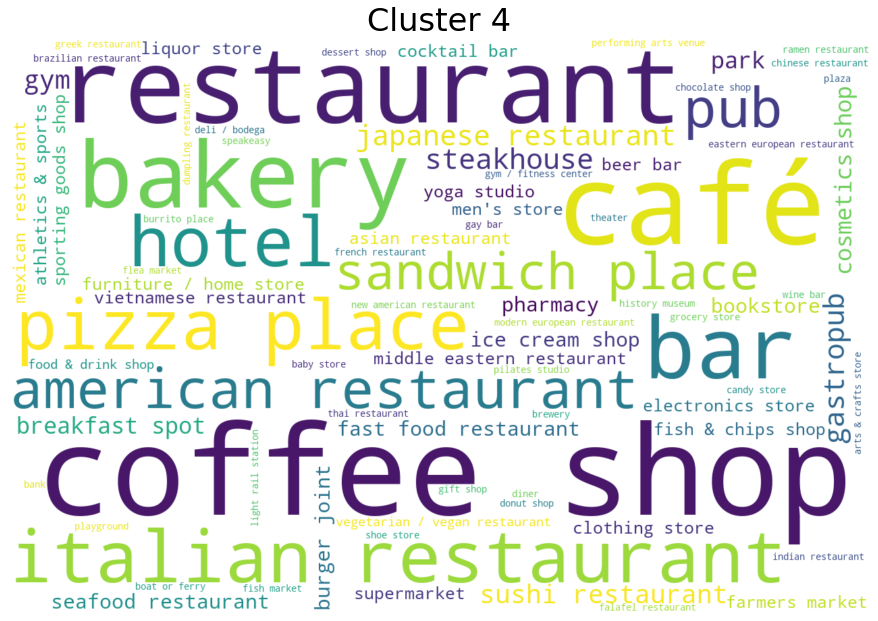

In [62]:
# plot the WordCloud image                        
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(cl4, interpolation="bilinear") 
plt.axis("off") 
plt.title("Cluster 4", fontdict=fontparam)
plt.tight_layout(pad = 0) 
  
plt.show() 